# Introduction

This project employs an unsupervised machine learning algorithm designed to cluster Airbnb rental properties in Chicago. The analysis leverages property-related features, encompassing continuous, categorical, and free-text data. Prior to training the final model, an Agglomerative clustering algorithm, additional NLP features were engineered from the raw text descriptions.

The data, freely available from Inside Airbnb (https://insideairbnb.com/get-the-data/), was last updated on March 11, 2025. This dataset includes 8,748 properties (rows) and 79 features (columns), with detailed feature descriptions provided in a data dictionary at: https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit?usp=sharing

# Inputs

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic
import re

import nltk

from Levenshtein import distance as levenshtein_distance
from rake_nltk import Rake
from collections import Counter
import ast

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA

In [428]:
df = pd.read_csv('listings.csv')

# EDA

## Raw Data Exploration

In [429]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8748 entries, 0 to 8747
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            8748 non-null   int64  
 1   listing_url                                   8748 non-null   object 
 2   scrape_id                                     8748 non-null   int64  
 3   last_scraped                                  8748 non-null   object 
 4   source                                        8748 non-null   object 
 5   name                                          8748 non-null   object 
 6   description                                   8585 non-null   object 
 7   neighborhood_overview                         5099 non-null   object 
 8   picture_url                                   8748 non-null   object 
 9   host_id                                       8748 non-null   i

Text(0, 0.5, 'Number of Missing Values')

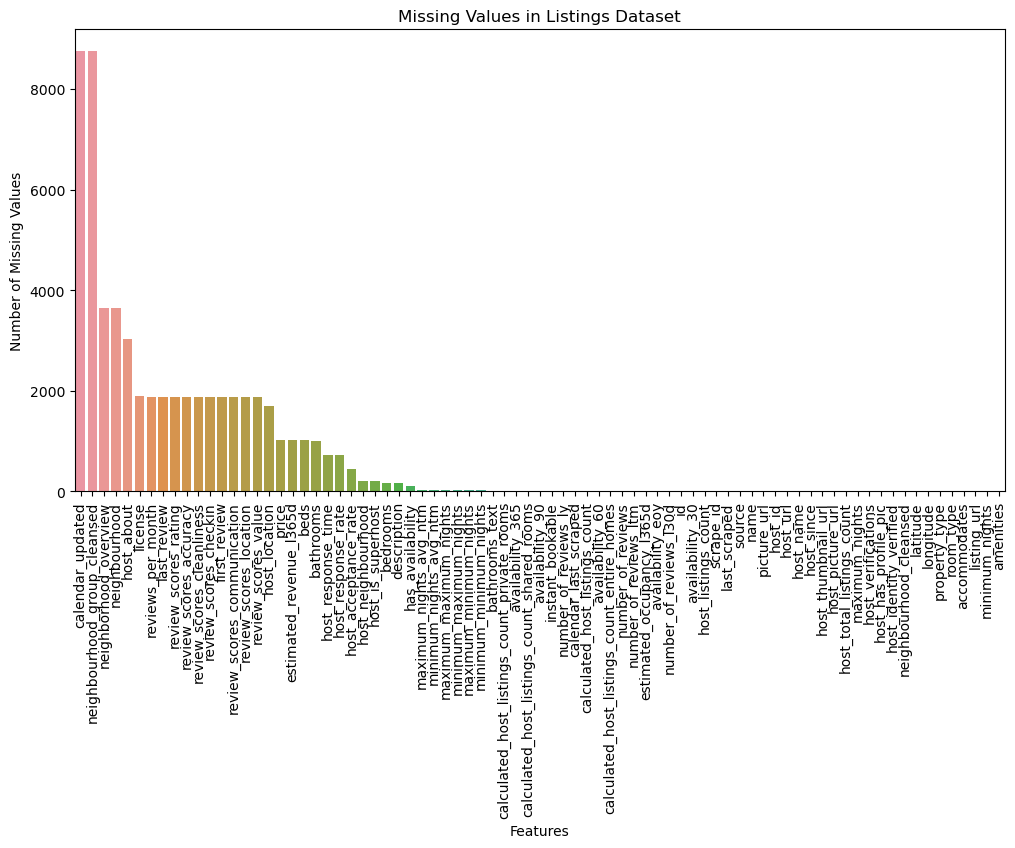

In [430]:
plt.figure(figsize=(12, 6))
plt.title('Missing Values in Listings Dataset')
sns.barplot(df.isnull().sum().sort_values(ascending= False).reset_index(), x = 'index', y = 0)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Number of Missing Values')

In [431]:
(df.isnull().sum()>0).sum()/len(df.columns)

0.45569620253164556

About 45% of the columns have at least 1 missing value.
The data dictionary Google spreadsheet was downloaded as csv (named as listings_dictionary.csv) and cleaned for ease of reading.
This data dictionary will be used to confirm data type and check if columns are required.

In [432]:
data_dict = pd.read_csv('listings_dictionary.csv', skiprows = 7).fillna('-')

In [433]:
data_dict.head()

,Field,Type,Calculated,Description,Reference
0,id,integer,-,Airbnb's unique identifier for the listing,-
1,listing_url,text,y,-,-
2,scrape_id,bigint,y,"Inside Airbnb ""Scrape"" this was part of",-
3,last_scraped,datetime,y,"UTC. The date and time this listing was ""scrap...",-
4,source,text,-,"One of ""neighbourhood search"" or ""previous scr...",-


In [434]:
info_df = pd.concat([df.dtypes,df.isnull().sum()], axis = 1)
info_df = info_df.reset_index().rename({'index':'Field',0:'df dtype',1:'null_perc'}, axis = 1)
info_df['null_perc'] = info_df['null_perc']/len(df)
info_df = info_df.merge(data_dict, on = 'Field', how = 'inner')

In [435]:
info_df.head()

,Field,df dtype,null_perc,Type,Calculated,Description,Reference
0,id,int64,0.0,integer,-,Airbnb's unique identifier for the listing,-
1,listing_url,object,0.0,text,y,-,-
2,scrape_id,int64,0.0,bigint,y,"Inside Airbnb ""Scrape"" this was part of",-
3,last_scraped,object,0.0,datetime,y,"UTC. The date and time this listing was ""scrap...",-
4,source,object,0.0,text,-,"One of ""neighbourhood search"" or ""previous scr...",-


Some columns need data type munging.

In [436]:
info_df[info_df['null_perc']>0].sort_values('null_perc', ascending = False)

,Field,df dtype,null_perc,Type,Calculated,Description,Reference
50,calendar_updated,float64,1.000000,date,-,-,-
30,neighbourhood_group_cleansed,float64,1.000000,text,y,The neighbourhood group as geocoded using the ...,-
8,neighborhood_overview,object,0.417124,text,-,Host's description of the neighbourhood,-
28,neighbourhood,object,0.417010,text,-,-,-
15,host_about,object,0.345793,text,-,Description about the host,-
69,license,object,0.217535,text,-,The licence/permit/registration number,-
75,reviews_per_month,float64,0.214678,numeric,y,The average number of reviews per month the li...,-
68,review_scores_value,float64,0.214678,-,-,-,-
60,first_review,object,0.214678,date,y,The date of the first/oldest review,-
63,review_scores_accuracy,float64,0.214678,-,-,-,-


Calendar updated and neighborhood group cleaned are both columns with all null values. Other columns with over 20% missing values are concerning and should be investigated further.

## Data Preprocessing


### Dropping Columns

Columns that do not contribute any information to our project scope are dropped prior to any further data cleaning:
- scrape_id, last_scraped, source, listing_url, calendar_updated, calendar_last_scraped
    - stationary values as the data does not go back further than one scrape
- name, picture_url, host_url, host_thumbnail_url, host_picture_url, host_id, host_location, host_since, host_about, host_response_time,
       host_response_rate, host_acceptance_rate, host_is_superhost,
       host_total_listings_count, host_verifications,host_name
       host_has_profile_pic, host_identity_verified,calculated_host_listings_count,
       calculated_host_listings_count_entire_homes,
       calculated_host_listings_count_private_rooms,
       calculated_host_listings_count_shared_rooms, first_review, last_review
    - irrelevant to the project
- host_neighborhood, neighborhood, neighbourhood_group_cleansed, host_listings_count, reviews_per_month, property_type, neighbourhood_cleansed, neighborhood_overview
    - other related or calculated column that provides pertinent information is included
    - Latitude and Longitude will be used to provide distance feature
- min_min, min_max, max_min, max_max, availability_, has_availability, availability_eoy, estimated_occupancy_l365d, estimated_revenue_l365d
    - looks into the future, and therefore, dropped to minimize data leakage

In [437]:
drop_col = ['listing_url', 'scrape_id', 'last_scraped', 'source','calendar_last_scraped','calendar_updated','first_review','last_review',
              'name','picture_url','host_url','host_thumbnail_url', 'host_picture_url', 'host_about','host_name',
              'host_response_time','host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
              'host_total_listings_count', 'host_verifications',
              'host_has_profile_pic', 'host_identity_verified',
              'host_neighbourhood', 'host_listings_count','neighbourhood','host_id','host_since', 'host_location',
               'neighbourhood_group_cleansed','neighbourhood_cleansed','reviews_per_month','property_type','neighborhood_overview',
              'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
              'maximum_minimum_nights', 'minimum_maximum_nights',
              'maximum_maximum_nights', 'minimum_nights_avg_ntm',
              'maximum_nights_avg_ntm','availability_30', 'availability_60', 'availability_90',
              'availability_365','has_availability','availability_eoy','estimated_occupancy_l365d','estimated_revenue_l365d',
              'calculated_host_listings_count',
              'calculated_host_listings_count_entire_homes',
              'calculated_host_listings_count_private_rooms',
              'calculated_host_listings_count_shared_rooms']

In [438]:
df = df.drop(drop_col, axis = 1)
info_df = info_df[~info_df['Field'].isin(drop_col)]

In [439]:
info_df[info_df['null_perc']>0].sort_values('null_perc', ascending = False)

,Field,df dtype,null_perc,Type,Calculated,Description,Reference
69,license,object,0.217535,text,-,The licence/permit/registration number,-
62,review_scores_rating,float64,0.214678,-,-,-,-
63,review_scores_accuracy,float64,0.214678,-,-,-,-
64,review_scores_cleanliness,float64,0.214678,-,-,-,-
65,review_scores_checkin,float64,0.214678,-,-,-,-
66,review_scores_communication,float64,0.214678,-,-,-,-
67,review_scores_location,float64,0.214678,-,-,-,-
68,review_scores_value,float64,0.214678,-,-,-,-
41,price,object,0.117741,currency,-,daily price in local currency.\nNOTE: the $ si...,-
39,beds,float64,0.116941,integer,-,The number of bed(s),-


### Dropping Rows
It appears that some properties are new and are missing review information (about 21.5%). These properties will be removed prior to further analysis. 

Additionally, properties that do not have a description will also be removed. It is a key feature we will be using NLP on, and there are less than 2% of properties without a description.

In [440]:
df = df[(df['review_scores_rating'].notnull())&(df['description'].notnull())].reset_index(drop = True)

### Data Type Munging

In [441]:
df['price'] = df['price'].str.replace(r'[$,]', '', regex = True).astype(float)

### Cleaning bathrooms_text

In [442]:
df['bathrooms_text'].str.split().str[-1].value_counts()

bath         4357
baths        2449
Half-bath       3
half-bath       2
Name: bathrooms_text, dtype: int64

In [443]:
df[df['bathrooms_text'].str.contains('share', na= False, case = False)]['bathrooms_text'].str.split().str[-1].value_counts()

bath         589
baths        325
half-bath      1
Name: bathrooms_text, dtype: int64

In [444]:
df[df['bathrooms_text'].str.contains('half-bath', na = False, case = False)][['bathrooms','bathrooms_text']]


,bathrooms,bathrooms_text
401,0.5,Shared half-bath
1927,NaN,Half-bath
5720,0.5,Half-bath
5914,0.5,Half-bath
6479,0.5,Private half-bath


In [445]:
df['bathrooms_text'].str.split().str[0].unique()

array(['1', '2', '1.5', '3', '2.5', '3.5', '11', nan, '4', '0', 'Shared',
       '4.5', '5', '11.5', '6.5', '5.5', '7', 'Half-bath', '6', '9.5',
       '7.5', '8', '8.5', '9', 'Private'], dtype=object)

In [446]:
df['bathrooms_text'].str.split().str[1].unique()

array(['shared', 'bath', 'baths', 'private', nan, 'half-bath'],
      dtype=object)

It appears there are shared baths. Check if there are other categories of bath rooms.

Assume if not listed as shared, it is private.

In [447]:
df['bathrooms_shared'] = np.where(df['bathrooms_text'].str.contains('share', 
                                                                                na= False, case = False),1,0)
df = df.drop('bathrooms_text', axis = 1)

### Replacing license to a categorical variable



In [448]:
pd.Series(np.where(df['license'].fillna('null').str.replace(r'[A-Za-z]', '', regex=True).str.isnumeric(),
         'Licensed',df['license'])).value_counts()

Licensed                                                                                  5872
City registration pending                                                                  178
32+ Days Listing                                                                            61
32+days Listing                                                                             27
City Registration Pending                                                                    7
Registered                                                                                   4
Per city of chicago, no registration # is needed since this rental is 32 days or more.       1
DOB-111617                                                                                   1
City registration pending R19000048093                                                       1
Applied for registration                                                                     1
Chicago registration number pending               

In [449]:
pd.Series(np.where((df['license'].str.contains('32', na = False))&\
         (df['license'].str.contains('day', na = False, case = False)),'NA',
         np.where((df['license'].str.contains('pending', na = False, case = False))|\
         (df['license'].str.contains('applied', na = False, case = False)), 'PEND',
                 np.where((df['license'].str.contains(r'\d',regex = True)|\
                           (df['license'].str.contains('registered', na = False, case = False))), 'LICENSE',np.nan)))).value_counts()


LICENSE    5879
nan         660
PEND        195
NA           89
dtype: int64

In [450]:
df['license'] = np.where((df['license'].str.contains('32', na = False))&\
         (df['license'].str.contains('day', na = False, case = False)),'NA',
         np.where((df['license'].str.contains('pending', na = False, case = False))|\
         (df['license'].str.contains('applied', na = False, case = False)), 'PEND',
                 np.where((df['license'].str.contains(r'\d',regex = True)|\
                           (df['license'].str.contains('registered', na = False, case = False))), 'LICENSE','UNK')))


#### Creating Geo-Features
- Distance from the Bean

In [451]:
def calculate_to_loc(dataframe, fixed_point): 
    return dataframe.apply(
        lambda row: geodesic((row['latitude'], row['longitude']), fixed_point).km,
        axis=1
    )

In [452]:
df['latitude'].isnull().sum(), df['longitude'].isnull().sum()

(0, 0)

In [453]:
fixed_point = (41.892423, -87.634049) # Bean (Downtown Chicago)
fixed_lat = 41.892423
fixed_lon = -87.634049

df['km_DT'] = calculate_to_loc(df, fixed_point)
df['lat_diff'] = df['latitude'] - fixed_lat
df['lon_diff'] = df['longitude'] - fixed_lon

In [454]:
df.drop(['latitude', 'longitude'], axis = 1, inplace = True)

### Free Text Fields
- Description, amenities

In [455]:
df.head().T


,0,1,2,3,4
id,2384,7126,10945,28749,71930
description,Solo Hyde Park visitors are invited stay in th...,A very small studio in a wonderful neighborhood.,Beautiful first floor apartment in Historic Ol...,Located on a peaceful treelined street in ener...,A peaceful shared space in Chicago's Ukrainian...
room_type,Private room,Entire home/apt,Entire home/apt,Entire home/apt,Private room
accommodates,1,2,4,6,2
bathrooms,1.0,1.0,1.0,2.0,1.0
bedrooms,1.0,1.0,2.0,3.0,1.0
beds,1.0,1.0,2.0,3.0,1.0
amenities,"[""Host greets you"", ""Hot water kettle"", ""Carbo...","[""Window AC unit"", ""Central heating"", ""Dishes ...","[""Window AC unit"", ""Dishes and silverware"", ""H...","[""Dishes and silverware"", ""TV with DVD player,...","[""Dishes and silverware"", ""Dedicated workspace..."
price,125.0,81.0,187.0,196.0,76.0
number_of_reviews,250,569,117,244,129


#### Removing Emojis

In [456]:
def contains_emoji(text):
    if pd.isna(text):
        return 0
    text = str(text)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002700-\U000027BF"  # Dingbats
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001F700-\U0001F77F"  # Alchemical Symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F100-\U0001F1FF"  # Enclosed Alphanumeric Supplement
                               u"\U0001F200-\U0001F2FF"  # Enclosed Ideographic Supplement
                               u"\U0001F300-\U0001F5FF"  # Miscellaneous Symbols and Pictographs
                               u"\U0001F600-\U0001F64F"  # Emoticons
                               u"\U0001F650-\U0001F67F"  # Ornamental Dingbats
                               u"\U0001F680-\U0001F6FF"  # Transport and Map Symbols
                               u"\U0001F700-\U0001F77F"  # Alchemical Symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               "]+", flags=re.UNICODE)
    return 1 if emoji_pattern.search(text) else 0

def remove_emojis(text):
    if pd.isna(text):
        return text
    text = str(text)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002700-\U000027BF"  # Dingbats
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001F700-\U0001F77F"  # Alchemical Symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F100-\U0001F1FF"  # Enclosed Alphanumeric Supplement
                               u"\U0001F200-\U0001F2FF"  # Enclosed Ideographic Supplement
                               u"\U0001F300-\U0001F5FF"  # Miscellaneous Symbols and Pictographs
                               u"\U0001F600-\U0001F64F"  # Emoticons
                               u"\U0001F650-\U0001F67F"  # Ornamental Dingbats
                               u"\U0001F680-\U0001F6FF"  # Transport and Map Symbols
                               u"\U0001F700-\U0001F77F"  # Alchemical Symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [457]:
df['emoji_description'] = df['description'].apply(contains_emoji).values

In [458]:
df['description'] = df['description'].apply(remove_emojis)

# Feature Engineering (NLP)

### Key Phrase and Keyword Extraction
- Using brute fource (occurance) + RAKE algorithim to identify top keywords and key phrases.
- Uses levenshtein distance to keep "unique" terms.
- Vectorize description field.

In [459]:
def preprocess_text(text):
    text = text.lower()
    # remove HTML tags
    text = re.sub(r'<[^>]+>', ' ', text)
    # remove special characters
    text = re.sub(r'[^\w\s]', ' ', text)
    # remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

stop = set(nltk.corpus.stopwords.words('english'))

# Extract keywords from text: using brute count
def extract_keywords_count(text):
    words = text.split()
    #filter keywords for at least > 4 charecters and not a stop word
    words = list(filter(lambda x: len(x) >= 4 and x not in stop, words))
    # only top 10 occurances
    keywords = [element[0] for element in Counter(words).most_common(10)]
    return keywords

# Getting the key phrases using RAKE Algorithim
def extract_key_phrase(text):
    key_phrases = Rake()
    key_phrases.extract_keywords_from_text(preprocess_text(text))
    ranked_phrases = key_phrases.get_ranked_phrases()
    ranked_phrases = list(dict.fromkeys(ranked_phrases))[:10]
    return ranked_phrases

# Unique between key words brute count + keyphrases RAKE
def merge_description(lst):
    if len(lst) <3:
        return lst
    filtered_list =[lst[0]]
    for item in lst[1:]:
        distance_score = 1-(levenshtein_distance(item.replace(' ',''), lst[0].replace(' ','')) / (max(len(item.replace(' ','')),len(lst[0].replace(' ','')))))
        if distance_score <= .5:
            filtered_list.append(item)
    return filtered_list

In [460]:
df['description_1'] = df['description'].map(preprocess_text).map(extract_keywords_count)
df['description_2'] = df['description'].map(preprocess_text).map(extract_key_phrase)
df['description_v'] = df.apply(lambda row: merge_description(list(set(row['description_1']).union(set(row['description_2'])))), axis = 1).apply(lambda x: ' '.join(x))
df.drop(['description_1','description_2'], axis = 1, inplace = True)

### NMF to cluster the description keywords

In [461]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.85, min_df=2, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['description_v'])

#### Grid Search Number of Clusters

  N_components: 2, Reconstruction Error: 80.1541
  N_components: 7, Reconstruction Error: 78.1745
  N_components: 12, Reconstruction Error: 77.0799
  N_components: 17, Reconstruction Error: 76.1293
  N_components: 22, Reconstruction Error: 75.2709
  N_components: 27, Reconstruction Error: 74.4900
  N_components: 32, Reconstruction Error: 73.7519
  N_components: 37, Reconstruction Error: 73.0771
  N_components: 42, Reconstruction Error: 72.3759
  N_components: 47, Reconstruction Error: 71.7331
  N_components: 52, Reconstruction Error: 71.1636
  N_components: 57, Reconstruction Error: 70.5129
  N_components: 62, Reconstruction Error: 69.9972
  N_components: 67, Reconstruction Error: 69.4567
  N_components: 72, Reconstruction Error: 68.9205
  N_components: 77, Reconstruction Error: 68.3953
  N_components: 82, Reconstruction Error: 67.8392
  N_components: 87, Reconstruction Error: 67.3672
  N_components: 92, Reconstruction Error: 66.9096
  N_components: 97, Reconstruction Error: 66.4651


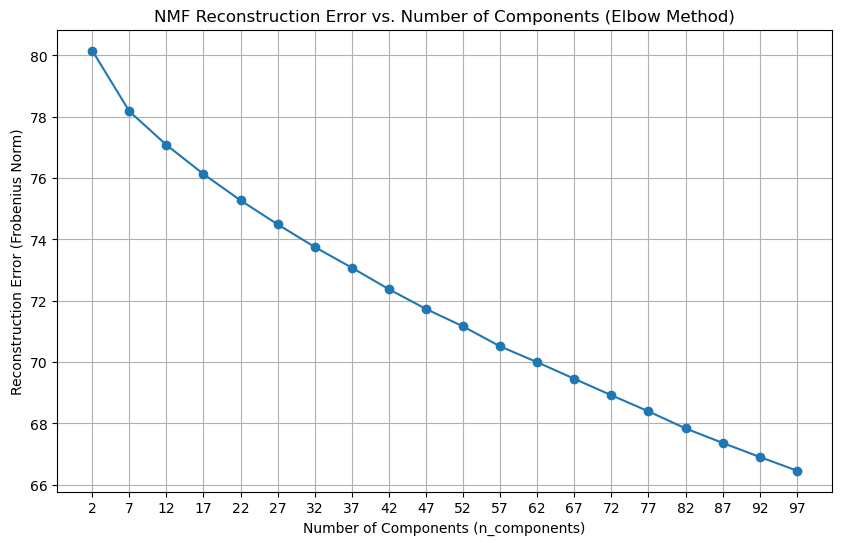

In [406]:
reconstruction_errors = []
components_range = range(2, 100, 5)

for n_comp in components_range:
    nmf_model_eval = NMF(n_components=n_comp, random_state=1, init='nndsvda', max_iter=500)
    nmf_model_eval.fit(tfidf_matrix)
    reconstruction_errors.append(nmf_model_eval.reconstruction_err_)
    print(f"  N_components: {n_comp}, Reconstruction Error: {nmf_model_eval.reconstruction_err_:.4f}")
plt.figure(figsize=(10, 6))
plt.plot(components_range, reconstruction_errors, marker='o', linestyle='-')
plt.title('NMF Reconstruction Error vs. Number of Components (Elbow Method)')
plt.xlabel('Number of Components (n_components)')
plt.ylabel('Reconstruction Error (Frobenius Norm)')
plt.xticks(list(components_range)) # Ensure all component numbers are shown on x-axis
plt.grid(True)
plt.show()

While there is no clear "elbow", there's a significant improvement going from 2 to 12 components.The decrease from 12 to 17 is still noticeable (0.9506). After 17 components, the decreases become more consistent and smaller (generally below 0.8 and moving towards 0.4-0.5).

In [462]:
n_cluster = 17
nmf = NMF(n_components=n_cluster, random_state=1, init='nndsvda', max_iter=500)
nmf_W = nmf.fit_transform(tfidf_matrix) # Document-topic matrix
nmf_H = nmf.components_ # Topic-word matrix

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
    print("\n")

# Get the feature names (words) from the TF-IDF vectorizer
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# Display the top words for each topic
num_top_words = 5 # Number of top words to display per topic
print(f"Top {num_top_words} words per topic:\n")
display_topics(nmf, tfidf_feature_names, num_top_words)

Top 5 words per topic:

Topic 1:
minutes away downtown chicago drive
Topic 2:
blueground home start living love
Topic 3:
centrally place located peaceful simple
Topic 4:
special rates message queen building
Topic 5:
room private shared bed living
Topic 6:
stylish space perfect experience vibrant
Topic 7:
walking chicago distance field attractions
Topic 8:
great place time comfortable family
Topic 9:
square logan blue line garden
Topic 10:
studio west away shops blue
Topic 11:
night river north level separate
Topic 12:
unit bedroom condo bath newly
Topic 13:
park lincoln wicker hyde grant
Topic 14:
access easy enjoy group perfectly
Topic 15:
walk minute min line wrigley
Topic 16:
free parking street quiet safe
Topic 17:
apartment bedroom fully furnished living




In [463]:
topic_feature_names = [f'nmf_topic_{i}' for i in range(n_cluster)]

# Create a DataFrame from nmf_W with the new column names
nmf_df = pd.DataFrame(nmf_W, columns=topic_feature_names, index=df.index)

# Concatenate the original DataFrame with the new NMF features DataFrame
df = pd.concat([df, nmf_df], axis=1)

In [464]:
df.drop(['description_v','description'], axis = 1, inplace = True)

### K-Means Clustering Amenities

In [465]:
df['amenities'] = df['amenities'].apply(ast.literal_eval).apply(lambda x: ' '.join(x))
tfidf_vectorizer = TfidfVectorizer(max_df=0.85, min_df=2, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['amenities'])

In [411]:
inertia_values = []
silhouette_scores = []
components_range = range(2, 21)

for n_comp in components_range:
    kmeans_model = KMeans(n_clusters=n_comp, random_state=1, n_init='auto')
    # Fit the model to the TF-IDF matrix
    kmeans_model.fit(tfidf_matrix)
    # Store the inertia value
    inertia_values.append(kmeans_model.inertia_)
    # Predict clusters for the current K
    cluster_labels = kmeans_model.predict(tfidf_matrix)
    # Calculate silhouette score
    score = silhouette_score(tfidf_matrix, cluster_labels)
    silhouette_scores.append(score)
    print(f"  K: {n_comp}, Inertia: {kmeans_model.inertia_:.2f}, Silhouette Score: {score:.3f}")

  K: 2, Inertia: 4760.26, Silhouette Score: 0.048
  K: 3, Inertia: 4673.09, Silhouette Score: 0.029
  K: 4, Inertia: 4537.48, Silhouette Score: 0.034
  K: 5, Inertia: 4464.52, Silhouette Score: 0.036
  K: 6, Inertia: 4398.31, Silhouette Score: 0.041
  K: 7, Inertia: 4347.70, Silhouette Score: 0.041
  K: 8, Inertia: 4279.05, Silhouette Score: 0.046
  K: 9, Inertia: 4198.69, Silhouette Score: 0.049
  K: 10, Inertia: 4127.57, Silhouette Score: 0.055
  K: 11, Inertia: 4087.27, Silhouette Score: 0.058
  K: 12, Inertia: 4051.29, Silhouette Score: 0.058
  K: 13, Inertia: 4006.76, Silhouette Score: 0.055
  K: 14, Inertia: 3968.52, Silhouette Score: 0.059
  K: 15, Inertia: 3947.68, Silhouette Score: 0.060
  K: 16, Inertia: 3903.22, Silhouette Score: 0.064
  K: 17, Inertia: 3871.57, Silhouette Score: 0.066
  K: 18, Inertia: 3839.72, Silhouette Score: 0.062
  K: 19, Inertia: 3829.00, Silhouette Score: 0.062
  K: 20, Inertia: 3824.01, Silhouette Score: 0.066


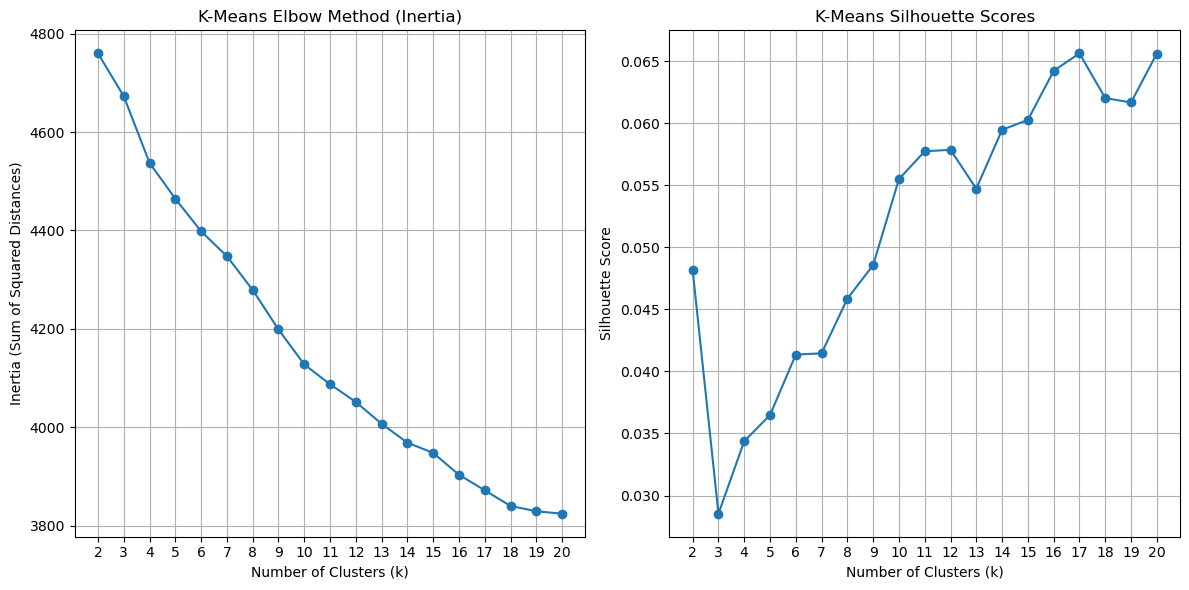

In [412]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(components_range, inertia_values, marker='o', linestyle='-')
plt.title('K-Means Elbow Method (Inertia)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.xticks(list(components_range))
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(components_range, silhouette_scores, marker='o', linestyle='-')
plt.title('K-Means Silhouette Scores')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(list(components_range))
plt.grid(True)

plt.tight_layout()
plt.show()

Elbow Method:
- K=2 to K=4: The inertia drops significantly (e.g., from 4760.26 to 4537.48, a drop of over 220 in two steps).
- K=4 to K=10: The drops continue but become somewhat less steep (e.g., from ~70 to ~80 per step of 1).
- K=10 to K=15: The reduction in inertia becomes noticeably smaller, hovering around 20-40 per step.
- K=15 to K=20: The drops become quite small, especially after K=18 (a drop of only 10.72) and K=19 (a drop of only 4.99).

Silhouette:
The scores start low and generally increase, but the overall values remain quite low (all below 0.1). This is common for text data, but it suggests the clusters might not be extremely distinct or well-separated. The score reaches a local high at K=10 (0.055). It then continues to gradually climb, reaching its highest observed values at K=17 (0.066) and K=20 (0.066).

K=17 is a strong candidate because it falls within the region where the inertia curve starts to flatten, and it achieves one of the highest silhouette scores.

In [466]:
kmeans_model = KMeans(n_clusters=17, random_state=1, n_init='auto')
cluster_assignments = kmeans_model.fit_predict(tfidf_matrix)
df['amenities_KMeans'] = cluster_assignments

In [467]:
df.drop(['amenities'], axis = 1, inplace = True)

# Feature Engineering (Encoding Categorical Variables)

In [472]:
df = pd.get_dummies(df, columns = ['room_type','license','instant_bookable','amenities_KMeans'], drop_first= True)

# Scaling Continuous Data
- Min Max Scalar was used to keep features at 0-1 unit

In [473]:
cont_cols = ['km_DT','lat_diff','lon_diff','bathrooms','bedrooms','beds','accommodates','price','number_of_reviews','number_of_reviews_ltm',
 'number_of_reviews_l30d','number_of_reviews_ly','review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value']


In [ ]:
scaler = MinMaxScaler()
continuous = scaler.fit_transform(df[cont_cols])
df[cont_cols] = continuous

In [480]:
df = df.set_index('id')

In [ ]:
df.to_pickle('data.pkl')
df = pd.read_pickle('data.pkl')

# Model Building
- Agglomerative Clustering
    - Does not require the number of clusters to be specified in advance

In [490]:
len(df.dropna()), len(df)

(6077, 6823)

Since there are not many missing NaNs, we will drop rows that contain a null value.

In [491]:
df = df.dropna()

## Dendogram

In [503]:
X = df.values

Euclidean distance is the most common and intuitive distance metric. It measures the "straight-line" distance between two points in a multi-dimensional space.

Since the features are all numerical and have been Min-Max scaled to a 0-1 range, Euclidean distance becomes very meaningful. 

Scaling ensures that no single feature dominates the distance calculation merely because it has a larger range of values. It implies that proximity in this feature space is a direct measure of similarity.

Ward linkage tends to produce clusters that are roughly spherical, compact, and of similar size. It's generally robust and less susceptible to noise compared to other linkage methods like 'single' linkage. It tries to keep the clusters as homogeneous as possible by minimizing the increase in total within-cluster variance.


{'icoord': [[25.0, 25.0, 35.0, 35.0],
  [15.0, 15.0, 30.0, 30.0],
  [45.0, 45.0, 55.0, 55.0],
  [22.5, 22.5, 50.0, 50.0],
  [5.0, 5.0, 36.25, 36.25],
  [65.0, 65.0, 75.0, 75.0],
  [85.0, 85.0, 95.0, 95.0],
  [105.0, 105.0, 115.0, 115.0],
  [125.0, 125.0, 135.0, 135.0],
  [155.0, 155.0, 165.0, 165.0],
  [145.0, 145.0, 160.0, 160.0],
  [175.0, 175.0, 185.0, 185.0],
  [215.0, 215.0, 225.0, 225.0],
  [205.0, 205.0, 220.0, 220.0],
  [195.0, 195.0, 212.5, 212.5],
  [180.0, 180.0, 203.75, 203.75],
  [235.0, 235.0, 245.0, 245.0],
  [285.0, 285.0, 295.0, 295.0],
  [275.0, 275.0, 290.0, 290.0],
  [265.0, 265.0, 282.5, 282.5],
  [255.0, 255.0, 273.75, 273.75],
  [240.0, 240.0, 264.375, 264.375],
  [191.875, 191.875, 252.1875, 252.1875],
  [152.5, 152.5, 222.03125, 222.03125],
  [130.0, 130.0, 187.265625, 187.265625],
  [110.0, 110.0, 158.6328125, 158.6328125],
  [90.0, 90.0, 134.31640625, 134.31640625],
  [70.0, 70.0, 112.158203125, 112.158203125],
  [20.625, 20.625, 91.0791015625, 91.0791015625]

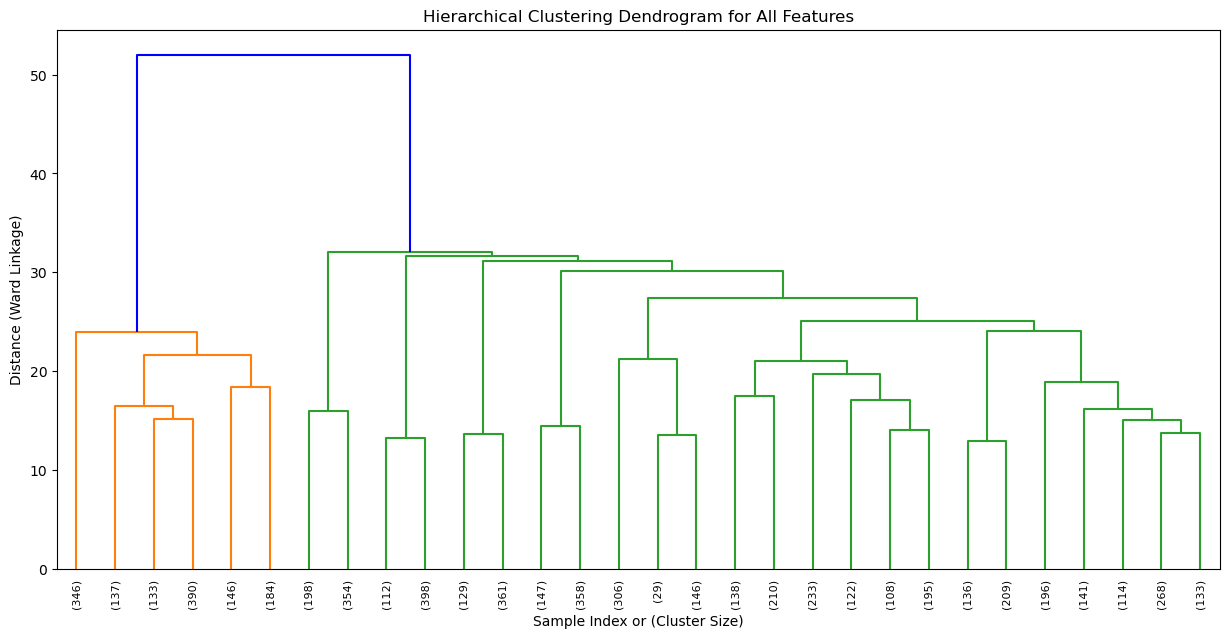

In [ ]:
Z = linkage(X, method='ward', metric='euclidean')

plt.figure(figsize=(15, 7))
plt.title('Hierarchical Clustering Dendrogram for All Features')
plt.xlabel('Sample Index or (Cluster Size)')
plt.ylabel('Distance (Ward Linkage)')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=30,  # show only the last 30 merges
    leaf_rotation=90,
    leaf_font_size=8,
    show_leaf_counts=True,
    above_threshold_color='blue',
)

Potential Ks

- K = 3
    - This would separate the data into the large orange group on the left and two large green groups on the right. This is a very broad clustering.
- K = 5 or K = 6
    - Cutting around a distance of 25-30 seems to reveal a good level of distinctness for a moderate number of clusters.
- K = 8 to K = 10
    - More granular clusters, cutting around distance 15-20 could yield 8 to 10 clusters.

## Base Model

In [ ]:
n_clusters = 5
base_model = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
base_model.fit(X)
labels = base_model.labels_

In [509]:
silhouette_avg = silhouette_score(X, labels)
davies_bouldin_idx = davies_bouldin_score(X, labels)
calinski_harabasz_idx = calinski_harabasz_score(X, labels)

print(f"Cluster Evaluation for K = {n_clusters}:")
print(f"Silhouette Score: {silhouette_avg:.3f} (Higher is better, range -1 to 1)")
print(f"Davies-Bouldin Index: {davies_bouldin_idx:.3f} (Lower is better, minimum 0)")
print(f"Calinski-Harabasz Index: {calinski_harabasz_idx:.3f} (Higher is better)")

Cluster Evaluation for K = 5:
Silhouette Score: 0.138 (Higher is better, range -1 to 1)
Davies-Bouldin Index: 1.888 (Lower is better, minimum 0)
Calinski-Harabasz Index: 558.849 (Higher is better)


The Silhouette Score of 0.138 is positive, indicating that data points are, on average, more similar to their own cluster than to others, its relatively low value suggests the clusters are not very distinct or well-separated, implying some overlap. This is further supported by the Davies-Bouldin Index of 1.888, which, being above 1, suggests that the within-cluster variance is large compared to the separation between clusters, pointing to less defined boundaries. The Calinski-Harabasz Index of 558.849 is a positive value, indicating some cluster structure.

### Visualizing Clusters

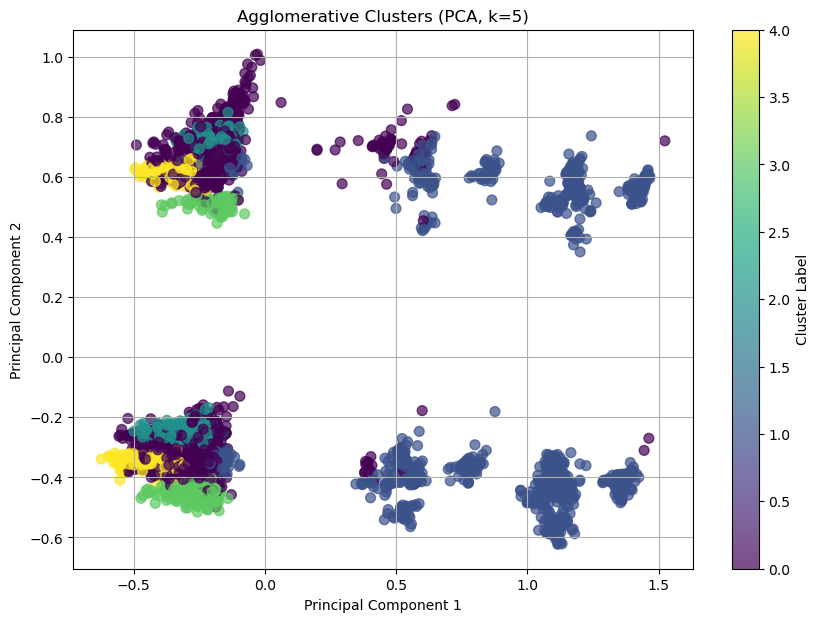

In [510]:
pca = PCA(n_components=2, random_state=1)
pca_components = pca.fit_transform(X)

plt.figure(figsize=(10, 7))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)
plt.title(f'Agglomerative Clusters (PCA, k={n_clusters})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.grid(True)

Cluster Separation and Distribution:

Vertical Separation by PC2: There's a very clear and strong separation along Principal Component 2 (the y-axis). The clusters tend to group into two distinct horizontal bands of -0.2 to -0.6 and 0.4 to 1.0.

The yellow and green clusters are quite compact and visually well-separated from the large dark purple and blue clusters. The teal clusters are also moderately well-seperated.
- Within the top band, we see distinct yellow, green, and a teal cluster.
- Similarly, within the bottom band, we see another set of yellow, green, and a teal cluster.

## GridSearch N Clusters

In [512]:
n_clusters_to_test = [3, 5, 6, 8, 9, 10]

results = []

for n_clusters in n_clusters_to_test:
    model = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
    labels = model.fit_predict(X) 
    silhouette_avg = silhouette_score(X, labels)
    davies_bouldin_idx = davies_bouldin_score(X, labels)
    calinski_harabasz_idx = calinski_harabasz_score(X, labels)
    # Store results
    results.append({
        'n_clusters': n_clusters,
        'silhouette_score': silhouette_avg,
        'davies_bouldin_index': davies_bouldin_idx,
        'calinski_harabasz_index': calinski_harabasz_idx
    })

results_df = pd.DataFrame(results)

In [513]:
results_df

,n_clusters,silhouette_score,davies_bouldin_index,calinski_harabasz_index
0,3,0.078284,2.029176,648.675525
1,5,0.138328,1.888306,558.849108
2,6,0.168462,1.878533,550.503589
3,8,0.196052,2.048123,524.217370
4,9,0.206415,1.951481,514.261610
5,10,0.213882,1.965713,510.894984


Trade-off at K=6:

This gives us the lowest Davies-Bouldin Index (1.878), indicating the best balance of compactness and separation.
The Silhouette Score is also reasonably good for this dataset (0.168), although not the absolute highest.
The Calinski-Harabasz index is still relatively high compared to higher K values, suggesting it retains some overall cluster density.

In [514]:
n_clusters = 6
base_model = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
base_model.fit(X)
labels = base_model.labels_

silhouette_avg = silhouette_score(X, labels)
davies_bouldin_idx = davies_bouldin_score(X, labels)
calinski_harabasz_idx = calinski_harabasz_score(X, labels)

print(f"Cluster Evaluation for K = {n_clusters}:")
print(f"Silhouette Score: {silhouette_avg:.3f} (Higher is better, range -1 to 1)")
print(f"Davies-Bouldin Index: {davies_bouldin_idx:.3f} (Lower is better, minimum 0)")
print(f"Calinski-Harabasz Index: {calinski_harabasz_idx:.3f} (Higher is better)")

Cluster Evaluation for K = 6:
Silhouette Score: 0.168 (Higher is better, range -1 to 1)
Davies-Bouldin Index: 1.879 (Lower is better, minimum 0)
Calinski-Harabasz Index: 550.504 (Higher is better)


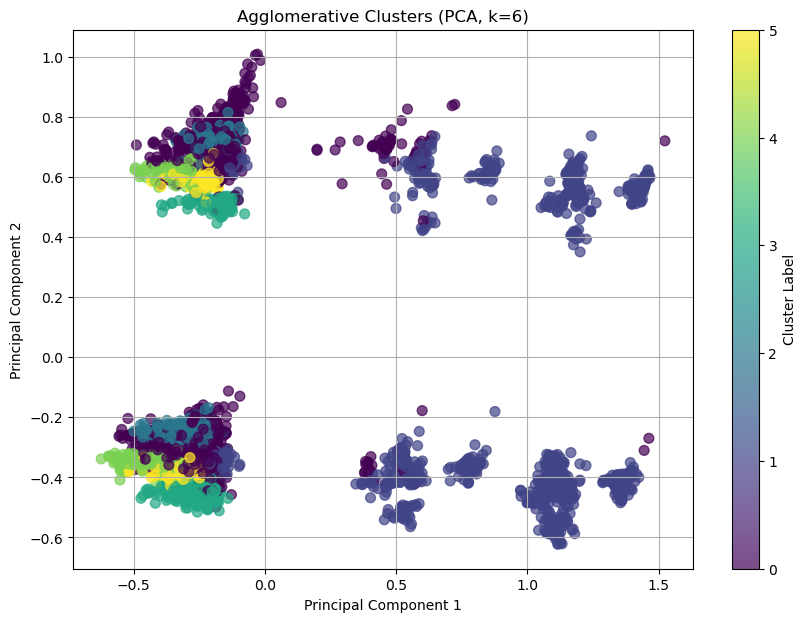

In [515]:
pca = PCA(n_components=2, random_state=1)
pca_components = pca.fit_transform(X)

plt.figure(figsize=(10, 7))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)
plt.title(f'Agglomerative Clusters (PCA, k={n_clusters})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.grid(True)

The k=6 plot reveals a slightly finer granularity on the left side, where the yellow and green clusters appear to differentiate further, indicating the additional cluster has likely refined the groupings within this dense region. 

This re-segmentation on the left contrasts with the largely unchanged distribution of the dominant right-side cluster across both visualizations.